In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

from spicy_snow.retrieval import retrieval_from_parameters

In [2]:
fig_dir = Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors/banner')

In [3]:
lievens_params = [2, 0.5, 0.44]
# wus_params = [2.5, 0.2, 0.55]
# wus_v2_params = [1.5, 0.1, 0.59]

in_dir = Path('~/spicy-snow/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()

# Create parameter space
A = np.round(np.arange(1, 3.1, 0.1), 2)
B = np.round(np.arange(0, 2.01, 0.1), 2)
C = np.round(np.arange(0, 1.001, 0.01), 2)

def bias(x, y): return np.mean(x - y)

def get_stats(x, y):
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

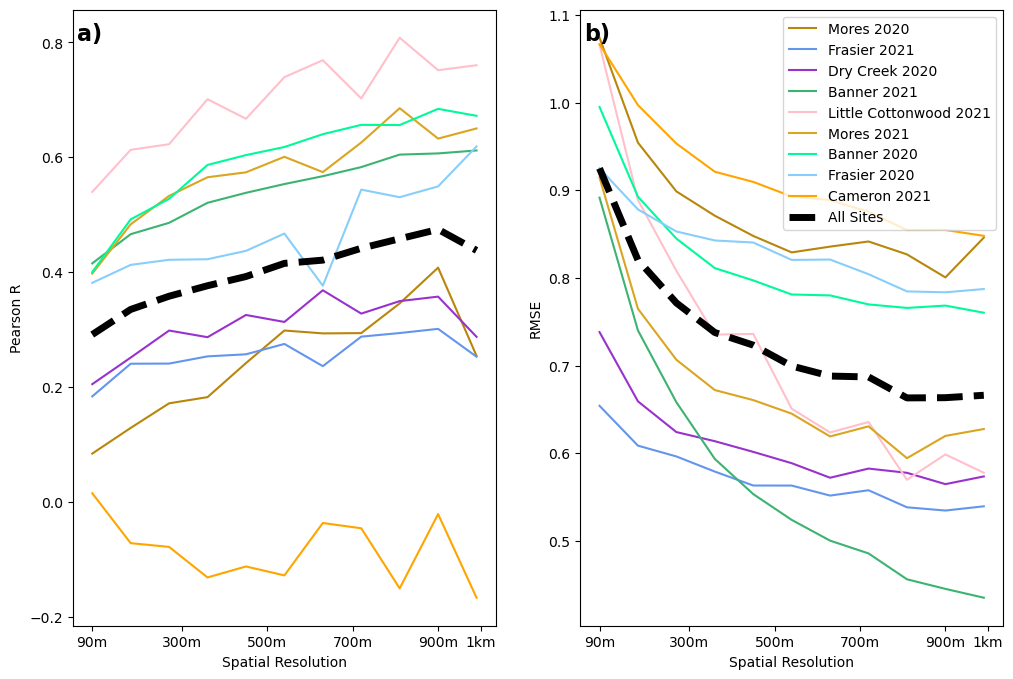

In [4]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

res = pd.DataFrame()

for fp in in_dir.glob('*.nc'):
    ds = xr.open_dataset(fp)

    if fp.stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])

    site_name = fp.stem.replace('_', ' ').split('-')[0]

    xs = []
    rs = []
    rmses = []
    for look in range(1, 12):
        ds_500 = ds.coarsen(x = look, y = look, boundary = 'pad').mean()
        r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))

        xs.append(look)
        rs.append(r)
        rmses.append(rmse)
        res.loc[fp.stem, f'r_{look}'] = r
        res.loc[fp.stem, f'rmse_{look}'] = rmse
        
    axes[0].plot(xs, rs, color = loc_colors[fp.stem])
    axes[1].plot(xs, rmses, color = loc_colors[fp.stem], label = site_name)

    # xs = []
    # rs = []
    # rmses = []
    # for look in range(1, 12):
    #     ds_500 = ds.coarsen(x = look, y = look, boundary = 'pad').mean()
    #     idx = ds_500['wet_snow'].sel(time = im_date, method = 'nearest') < 0.5
    #     if sum(idx.values.ravel()) < 10:
    #         continue
    #     r, b, mae, rmse  = get_stats(ds_500['lidar-sd'].where(idx), ds_500['snow_depth'].sel(time = im_date, method = 'nearest').where(idx))
    #     xs.append(look)
    #     rs.append(r)
    #     rmses.append(rmse)
    
    # axes[0].plot(xs, rs, color = loc_colors[fp.stem], linestyle = 'dashed')
    # axes[1].plot(xs, rmses, color = loc_colors[fp.stem], linestyle = 'dashed')

xs = []
rmses = []
rs = []
for n,v in res.mean().items():
    stat, look = n.split('_')
    if stat == 'r':
        rs.append(v)
        xs.append(int(look))
    elif stat == 'rmse':
        rmses.append(v)
axes[0].plot(xs, rs, color = 'black', linewidth = 5, linestyle = 'dashed')
axes[1].plot(xs, rmses, color = 'black', linewidth = 5, linestyle = 'dashed', label = 'All Sites')
    

for ax in axes:
    ax.set_xlabel('Spatial Resolution')
    ax.set_xticks([1, 300/90, 500/90, 700/90,900/90, 1000/90])
    ax.set_xticklabels(['90m','300m', '500m', '700m','900m','1km'])

axes[0].set_ylabel('Pearson R')
axes[1].set_ylabel('RMSE')
axes[1].legend()

for ax, letter in zip(axes.flatten(), ['a','b']):
    ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)

plt.savefig(fig_dir.joinpath('scale.png'))

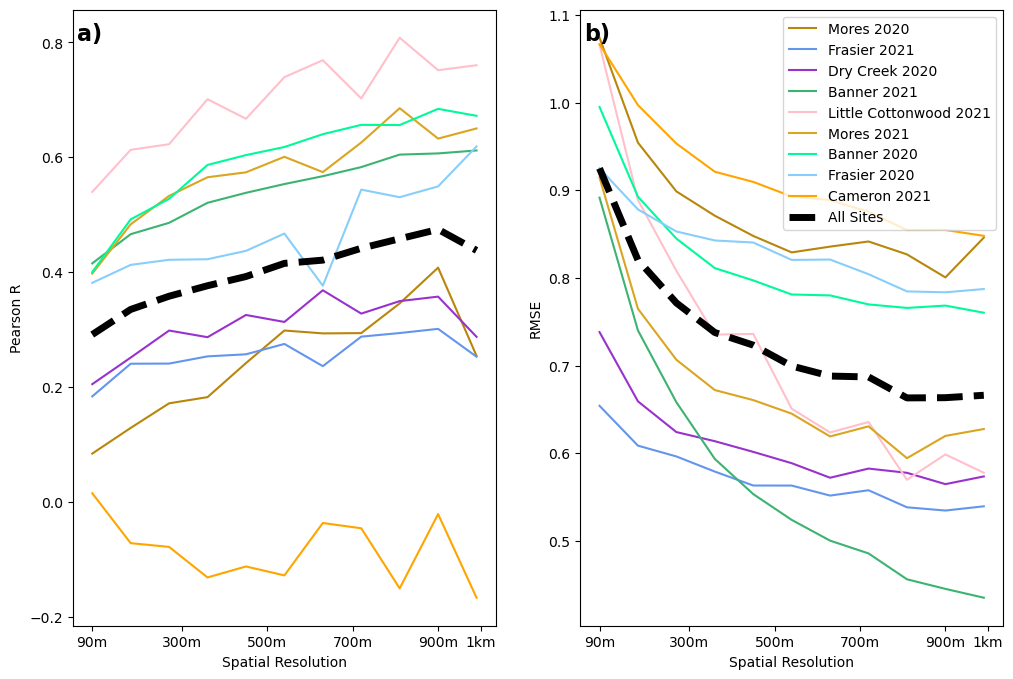

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

res = pd.DataFrame()

for fp in in_dir.glob('*.nc'):
    ds = xr.open_dataset(fp)

    if fp.stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])

    site_name = fp.stem.replace('_', ' ').split('-')[0]

    xs = []
    rs = []
    rmses = []
    for look in range(1, 12):
        ds_500 = ds.coarsen(x = look, y = look, boundary = 'pad').mean()
        r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))

        xs.append(look)
        rs.append(r)
        rmses.append(rmse)
        res.loc[fp.stem, f'r_{look}'] = r
        res.loc[fp.stem, f'rmse_{look}'] = rmse
        
    axes[0].plot(xs, rs, color = loc_colors[fp.stem])
    axes[1].plot(xs, rmses, color = loc_colors[fp.stem], label = site_name)

    # xs = []
    # rs = []
    # rmses = []
    # for look in range(1, 12):
    #     ds_500 = ds.coarsen(x = look, y = look, boundary = 'pad').mean()
    #     idx = ds_500['wet_snow'].sel(time = im_date, method = 'nearest') < 0.5
    #     if sum(idx.values.ravel()) < 10:
    #         continue
    #     r, b, mae, rmse  = get_stats(ds_500['lidar-sd'].where(idx), ds_500['snow_depth'].sel(time = im_date, method = 'nearest').where(idx))
    #     xs.append(look)
    #     rs.append(r)
    #     rmses.append(rmse)
    
    # axes[0].plot(xs, rs, color = loc_colors[fp.stem], linestyle = 'dashed')
    # axes[1].plot(xs, rmses, color = loc_colors[fp.stem], linestyle = 'dashed')

xs = []
rmses = []
rs = []
for n,v in res.mean().items():
    stat, look = n.split('_')
    if stat == 'r':
        rs.append(v)
        xs.append(int(look))
    elif stat == 'rmse':
        rmses.append(v)
axes[0].plot(xs, rs, color = 'black', linewidth = 5, linestyle = 'dashed')
axes[1].plot(xs, rmses, color = 'black', linewidth = 5, linestyle = 'dashed', label = 'All Sites')
    

for ax in axes:
    ax.set_xlabel('Spatial Resolution')
    ax.set_xticks([1, 300/90, 500/90, 700/90,900/90, 1000/90])
    ax.set_xticklabels(['90m','300m', '500m', '700m','900m','1km'])

axes[0].set_ylabel('Pearson R')
axes[1].set_ylabel('RMSE')
axes[1].legend()

for ax, letter in zip(axes.flatten(), ['a','b']):
    ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)

plt.savefig(fig_dir.joinpath('scale.png'))